In [1]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


1

In [10]:
import pandas as pd
from pydantic import BaseModel, Field
import datetime
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np  # For mathematical operations

class FlightDataAnalysis(BaseModel):
    class Config:
        arbitrary_types_allowed = True

    data_url: str = Field(default="https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false")
    date_created: datetime.date = Field(default_factory=datetime.date.today)
    airline_data: pd.DataFrame = None
    aircraft_data: pd.DataFrame = None
    airport_data: pd.DataFrame = None
    flight_routes: pd.DataFrame = None

    def __init__(self, **data):
        super().__init__(**data)
        download_dir = "./downloads"
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            response = requests.get(self.data_url, stream=True)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                zip_ref.extractall(download_dir)
        except requests.exceptions.HTTPError as err:
            os.rmdir(download_dir)
            raise ValueError(f"Download failed with status code {response.status_code}: {err}")

        try:
            self.airline_data = pd.read_csv(f"{download_dir}/airlines.csv")
            self.aircraft_data = pd.read_csv(f"{download_dir}/airplanes.csv")
            self.airport_data = pd.read_csv(f"{download_dir}/airports.csv")
            self.flight_routes = pd.read_csv(f"{download_dir}/routes.csv")
            self.flight_routes.drop(columns=["Airline", "Source airport", "Destination airport"], inplace=True)
            self.airport_data["Airport ID"] = self.airport_data["Airport ID"].astype(str)
        except FileNotFoundError as exc:
            raise FileNotFoundError(f"File not found during data setup: {exc}")

    def plot_flights_on_map(self, country: str, internal: bool = False, cutoff_distance: float = 1000):
        """
        Plot flight routes from a specified country on a world map using Cartopy.
        Differentiates between short-haul and long-haul flights based on cutoff_distance.

        Args:
        country (str): The name of the country.
        internal (bool, optional): If True, plot only internal flights within the same country.
        cutoff_distance (float, optional): The distance in kilometers to define short-haul flights. Defaults to 1000km.
        """
        def haversine(lon1, lat1, lon2, lat2):
            """
            Calculate the great circle distance between two points
            on the earth (specified in decimal degrees).
            """
            # Convert decimal degrees to radians
            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

            # Haversine formula
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            r = 6371 # Radius of earth in kilometers
            return c * r

        if country not in self.airport_data['Country'].values:
            print(f"Country '{country}' not found.")
            return

        country_airports = self.airport_data[self.airport_data["Country"] == country]

        if internal:
            filtered_flights = self.flight_routes[
                (self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])) &
                (self.flight_routes["Destination airport ID"].isin(country_airports["Airport ID"]))
            ]
        else:
            filtered_flights = self.flight_routes[
                self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])
            ]

        fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        for index, flight in filtered_flights.iterrows():
            source = country_airports[country_airports["Airport ID"] == flight["Source airport ID"]].iloc[0]
            dest = self.airport_data[self.airport_data["Airport ID"] == flight["Destination airport ID"]].iloc[0]

            distance = haversine(source["Longitude"], source["Latitude"], dest["Longitude"], dest["Latitude"])

            # Use blue for short-haul flights, and dark orange for long-haul flights for better visibility by color-blind users
            color = 'blue' if distance <= cutoff_distance else 'darkorange'

            plt.plot([source["Longitude"], dest["Longitude"]], [source["Latitude"], dest["Latitude"]],
                     color=color, linewidth=1, marker='o', transform=ccrs.Geodetic())

        ax.set_global()
        ax.set_title(f"Flights from {country}: Blue = Short-haul (<= {cutoff_distance}km), Dark Orange = Long-haul")
        plt.show()

# After defining the class, create an instance and call plot_flights_on_map as needed.


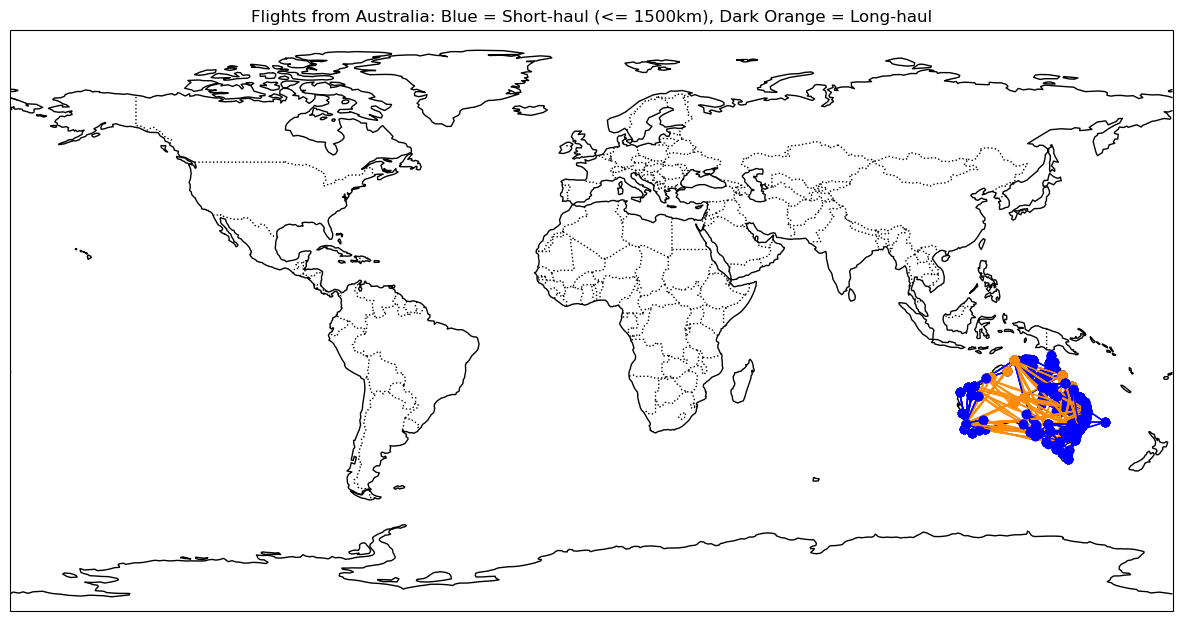

In [11]:
analysis = FlightDataAnalysis()

# Example: Plotting flights for Australia, distinguishing between short-haul and long-haul flights.
# Assuming short-haul flights are defined as those under 1500 kilometers.
analysis.plot_flights_on_map(country="Australia", internal=True, cutoff_distance=1500)


2

In [13]:
import pandas as pd
from pydantic import BaseModel, Field
import datetime
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np  # For mathematical operations

class FlightDataAnalysis(BaseModel):
    class Config:
        arbitrary_types_allowed = True

    data_url: str = Field(default="https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false")
    date_created: datetime.date = Field(default_factory=datetime.date.today)
    airline_data: pd.DataFrame = None
    aircraft_data: pd.DataFrame = None
    airport_data: pd.DataFrame = None
    flight_routes: pd.DataFrame = None

    def __init__(self, **data):
        super().__init__(**data)
        download_dir = "./downloads"
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            response = requests.get(self.data_url, stream=True)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                zip_ref.extractall(download_dir)
        except requests.exceptions.HTTPError as err:
            os.rmdir(download_dir)
            raise ValueError(f"Download failed with status code {response.status_code}: {err}")

        try:
            self.airline_data = pd.read_csv(f"{download_dir}/airlines.csv")
            self.aircraft_data = pd.read_csv(f"{download_dir}/airplanes.csv")
            self.airport_data = pd.read_csv(f"{download_dir}/airports.csv")
            self.flight_routes = pd.read_csv(f"{download_dir}/routes.csv")
            self.airport_data["Airport ID"] = self.airport_data["Airport ID"].astype(str)
        except FileNotFoundError as exc:
            raise FileNotFoundError(f"File not found during data setup: {exc}")

    def plot_flights_on_map(self, country: str, internal: bool = False, cutoff_distance: float = 1000):
        def haversine(lon1, lat1, lon2, lat2):
            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            r = 6371
            return c * r

        country_airports = self.airport_data[self.airport_data["Country"] == country]

        if internal:
            filtered_flights = self.flight_routes[
                (self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])) &
                (self.flight_routes["Destination airport ID"].isin(country_airports["Airport ID"]))
            ]
        else:
            filtered_flights = self.flight_routes[
                self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])
            ]

        fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
        ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.1)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.LAND, edgecolor='black')

        short_haul_routes = set()
        total_short_haul_distance = 0

        for _, flight in filtered_flights.iterrows():
            source_airport_id = flight["Source airport ID"]
            dest_airport_id = flight["Destination airport ID"]
            source = country_airports[country_airports["Airport ID"] == source_airport_id].iloc[0]
            dest = self.airport_data[self.airport_data["Airport ID"] == dest_airport_id].iloc[0]

            distance = haversine(source["Longitude"], source["Latitude"], dest["Longitude"], dest["Latitude"])

            route = frozenset([source_airport_id, dest_airport_id])

            if distance <= cutoff_distance and route not in short_haul_routes:
                short_haul_routes.add(route)
                total_short_haul_distance += distance
                color = 'blue'
            else:
                color = 'darkorange' if route not in short_haul_routes else 'grey'

            plt.plot([source["Longitude"], dest["Longitude"]], [source["Latitude"], dest["Latitude"]],
                     color=color, linewidth=1, marker='o', transform=ccrs.Geodetic())

        ax.set_global()
        ax.set_title(f"Flights from {country}: Blue = Short-haul (<= {cutoff_distance}km), Dark Orange = Long-haul")

        plt.annotate(f"Short-haul routes: {len(short_haul_routes)}\nTotal short-haul distance: {total_short_haul_distance:.2f} km",
                     xy=(0.05, 0.95), xycoords='axes fraction', backgroundcolor='white')

        plt.show()


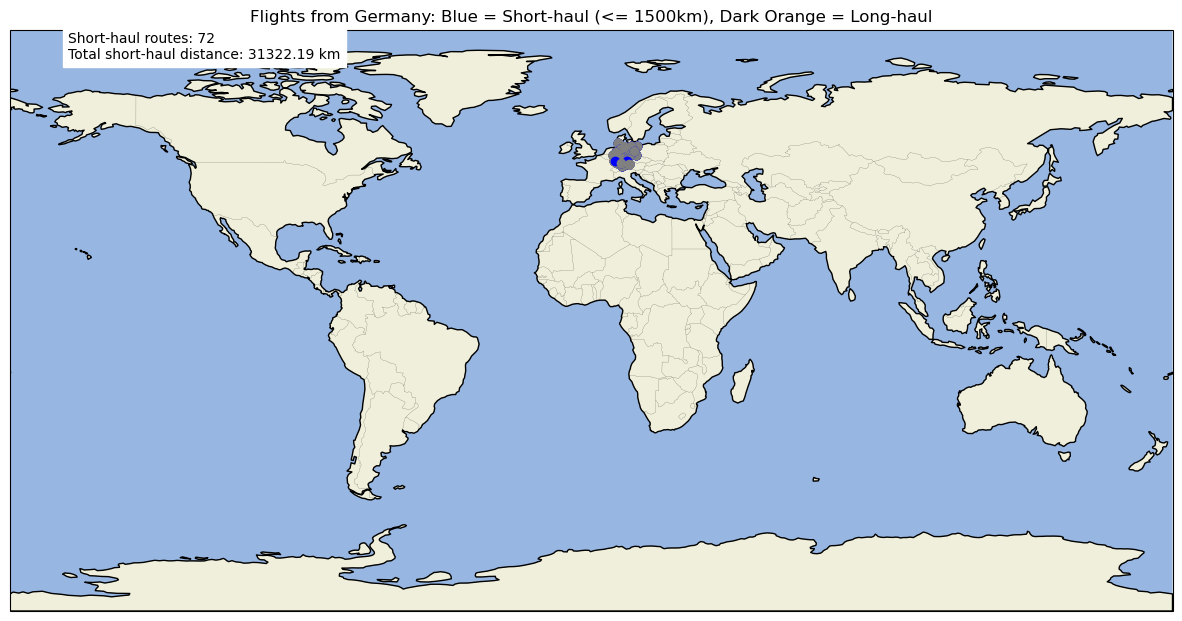

In [15]:
analysis = FlightDataAnalysis()

# Example: Plotting flights for Australia, distinguishing between short-haul and long-haul flights.
# Assuming short-haul flights are defined as those under 1500 kilometers.
analysis.plot_flights_on_map(country="Germany", internal=True, cutoff_distance=1500)


3

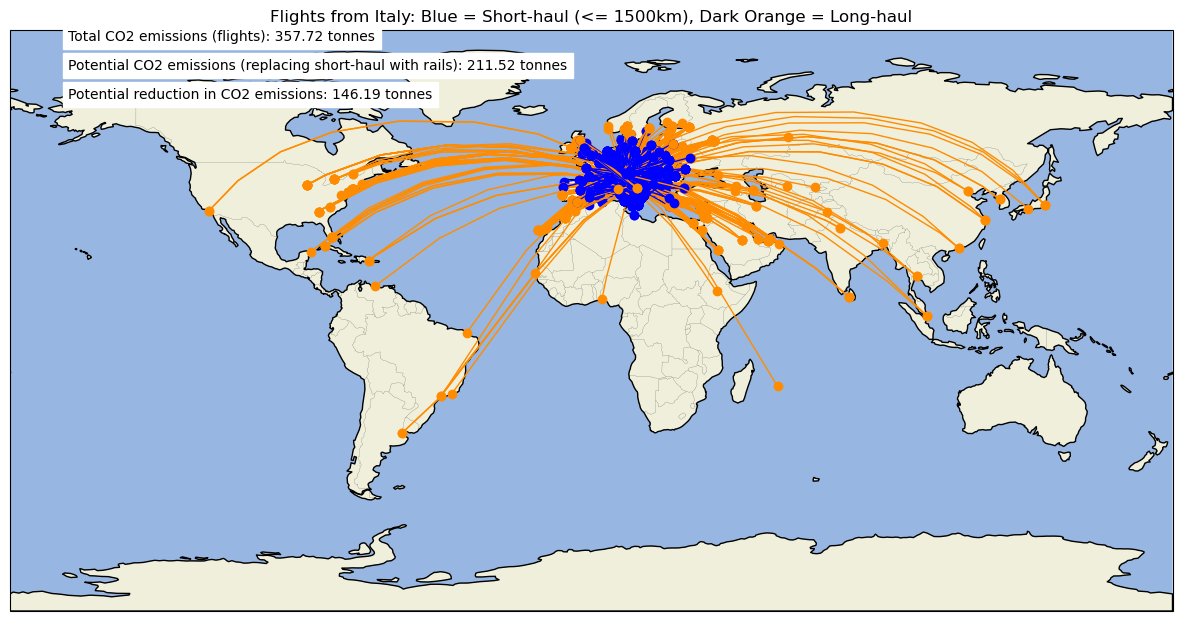

In [17]:
import pandas as pd
from pydantic import BaseModel, Field
import datetime
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np  # For mathematical operations

class FlightDataAnalysis(BaseModel):
    class Config:
        arbitrary_types_allowed = True

    data_url: str = Field(default="https://gitlab.com/adpro1/adpro2024/-/raw/main/Files/flight_data.zip?inline=false")
    date_created: datetime.date = Field(default_factory=datetime.date.today)
    airline_data: pd.DataFrame = None
    aircraft_data: pd.DataFrame = None
    airport_data: pd.DataFrame = None
    flight_routes: pd.DataFrame = None

    def __init__(self, **data):
        super().__init__(**data)
        download_dir = "./downloads"
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            response = requests.get(self.data_url, stream=True)
            response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                zip_ref.extractall(download_dir)
        except requests.exceptions.HTTPError as err:
            os.rmdir(download_dir)
            raise ValueError(f"Download failed with status code {response.status_code}: {err}")

        try:
            self.airline_data = pd.read_csv(f"{download_dir}/airlines.csv")
            self.aircraft_data = pd.read_csv(f"{download_dir}/airplanes.csv")
            self.airport_data = pd.read_csv(f"{download_dir}/airports.csv")
            self.flight_routes = pd.read_csv(f"{download_dir}/routes.csv")
            self.airport_data["Airport ID"] = self.airport_data["Airport ID"].astype(str)
        except FileNotFoundError as exc:
            raise FileNotFoundError(f"File not found during data setup: {exc}")

    def haversine(self, lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371  # Radius of earth in kilometers
        return c * r

    def plot_flights_on_map(self, country: str, internal: bool = False, cutoff_distance: float = 1000):
        country_airports = self.airport_data[self.airport_data["Country"] == country]
        if internal:
            filtered_flights = self.flight_routes[
                (self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])) &
                (self.flight_routes["Destination airport ID"].isin(country_airports["Airport ID"]))
            ]
        else:
            filtered_flights = self.flight_routes[
                self.flight_routes["Source airport ID"].isin(country_airports["Airport ID"])
            ]

        fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
        ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.1)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.LAND, edgecolor='black')

        short_haul_distance = 0
        long_haul_distance = 0

        for _, flight in filtered_flights.iterrows():
            source = country_airports[country_airports["Airport ID"] == flight["Source airport ID"]].iloc[0]
            dest = self.airport_data[self.airport_data["Airport ID"] == flight["Destination airport ID"]].iloc[0]

            distance = self.haversine(source["Longitude"], source["Latitude"], dest["Longitude"], dest["Latitude"])

            if distance <= cutoff_distance:
                short_haul_distance += distance
                color = 'blue'
            else:
                long_haul_distance += distance
                color = 'darkorange'

            plt.plot([source["Longitude"], dest["Longitude"]], [source["Latitude"], dest["Latitude"]],
                     color=color, linewidth=1, marker='o', transform=ccrs.Geodetic())

        ax.set_global()
        ax.set_title(f"Flights from {country}: Blue = Short-haul (<= {cutoff_distance}km), Dark Orange = Long-haul")

        # Calculate emissions
        flight_emissions_per_km = 133  # grams of CO2 equivalents per passenger kilometer for flights
        rail_emissions_per_km = 7     # grams of CO2 per passenger kilometer for rails
        total_flight_emissions = (short_haul_distance * flight_emissions_per_km + long_haul_distance * flight_emissions_per_km) / 1e6  # Convert to metric tonnes
        total_rail_emissions = (short_haul_distance * rail_emissions_per_km) / 1e6  # Convert to metric tonnes
        emissions_reduction = total_flight_emissions - (total_rail_emissions + long_haul_distance * flight_emissions_per_km / 1e6)

        plt.text(0.05, 1.0, f"Total CO2 emissions (flights): {total_flight_emissions:.2f} tonnes",
         transform=ax.transAxes, backgroundcolor='white', verticalalignment='top')
        plt.text(0.05, 0.95, f"Potential CO2 emissions (replacing short-haul with rails): {(total_rail_emissions + long_haul_distance * flight_emissions_per_km / 1e6):.2f} tonnes",
         transform=ax.transAxes, backgroundcolor='white', verticalalignment='top')
        plt.text(0.05, 0.90, f"Potential reduction in CO2 emissions: {emissions_reduction:.2f} tonnes",
         transform=ax.transAxes, backgroundcolor='white', verticalalignment='top')

        plt.show()

analysis = FlightDataAnalysis()
analysis.plot_flights_on_map(country="Italy", internal=False, cutoff_distance=1500)


i just take into consideration short haul flights since it's impossible to replace long-haul flights with rail services

In [7]:
https://travelandclimate.org/transport-calculations

SyntaxError: invalid syntax (2979511599.py, line 1)